#### LOAD LIBRARIES

In [261]:
import pandas as pd
import seaborn as sns
#%% packages
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


#### LOAD DATA

    - The data I have used contains PII. For a similar type of data, you can refer to this dataset: 15k Tweets About AI for Sentiment Analysis on Kaggle.

In [262]:

data = pd.read_csv('../Tweets.csv')
data

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative
...,...,...,...,...
27476,4eac33d1c0,wish we could come see u on Denver husband l...,d lost,negative
27477,4f4c4fc327,I`ve wondered about rake to. The client has ...,", don`t force",negative
27478,f67aae2310,Yay good for both of you. Enjoy the break - y...,Yay good for both of you.,positive
27479,ed167662a5,But it was worth it ****.,But it was worth it ****.,positive


#### CLEAN UP DATA

In [263]:
data = data.fillna('')
data=data[data['text'] != '']

In [264]:
### MAP Y Classes to a Number
# Define a dictionary to map sentiment classes to numerical values
cat_id = {
    'neutral': 1,   # 'neutral' sentiment mapped to 1
    'negative': 0,  # 'negative' sentiment mapped to 0
    'positive': 2   # 'positive' sentiment mapped to 2
}

# Use the map method to transform the 'sentiment' column into numerical values
data['class'] = data['sentiment'].map(cat_id)


## APPROACH 1 : CountVectorizer Method
    - Frequency Based Embedding with CountVectorizer

In [270]:
%%time

X = data['text'].values
y = data['class'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
print(f"X train: {X_train.shape}, y train: {y_train.shape}\nX test: {X_test.shape}, y test: {y_test.shape}")

vectorizer = CountVectorizer()

# Fit the vectorizer on the training data and transform the training data
X_train_counts = vectorizer.fit_transform(X_train)

# Transform the test data using the same vectorizer
X_test_counts = vectorizer.transform(X_test)

print(f"X_train_counts shape: {X_train_counts.shape}")
print(f"X_test_counts shape: {X_test_counts.shape}")

X train: (20610,), y train: (20610,)
X test: (6870,), y test: (6870,)
X_train_counts shape: (20610, 22150)
X_test_counts shape: (6870, 22150)
CPU times: user 154 ms, sys: 11.2 ms, total: 165 ms
Wall time: 171 ms


#### DATA LOADER

In [271]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
BATCH_SIZE = 512
NUM_EPOCHS = 80

class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X.toarray())
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    

train_ds = SentimentData(X= X_train_counts, y = y_train)
test_ds = SentimentData(X_test_counts, y_test)


# %% Dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=17500)

#### DEFINING SENTIMENT MODEL 

In [272]:
# %% Model
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN = 10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x


#%% Model, Loss and Optimizer
model = SentimentModel(NUM_FEATURES = X_train_counts.shape[1], NUM_CLASSES = 3)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())


#### TRAINING 

In [273]:
%%time
import torch
from sklearn.metrics import accuracy_score

# Assuming NUM_EPOCHS, model, optimizer, criterion, train_loader, and test_loader are defined
NUM_EPOCHS = 100
train_losses_cv = []
train_accuracies_cv = []

for e in range(NUM_EPOCHS):
    curr_loss = 0
    model.train()
    y_true_train = []
    y_pred_train = []
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())
        
        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        # For accuracy calculation
        y_pred_class = torch.argmax(y_pred_log, dim=1)
        y_true_train.extend(y_batch.cpu().numpy())
        y_pred_train.extend(y_pred_class.cpu().numpy())

    train_losses_cv.append(curr_loss)
    
    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    train_accuracies_cv.append(train_accuracy)
    
    print(f"Epoch {e}, Loss: {curr_loss}, Train Accuracy: {train_accuracy}")



Epoch 0, Loss: 45.26867461204529, Train Accuracy: 0.3814167879670063
Epoch 1, Loss: 42.110154926776886, Train Accuracy: 0.5988840368753032
Epoch 2, Loss: 38.26340037584305, Train Accuracy: 0.6834061135371179
Epoch 3, Loss: 34.38492560386658, Train Accuracy: 0.7352741387675885
Epoch 4, Loss: 30.906706392765045, Train Accuracy: 0.7721494420184376
Epoch 5, Loss: 27.95788538455963, Train Accuracy: 0.7961669092673459
Epoch 6, Loss: 25.372999668121338, Train Accuracy: 0.8156234837457544
Epoch 7, Loss: 23.192074239253998, Train Accuracy: 0.8335759340126152
Epoch 8, Loss: 21.33807000517845, Train Accuracy: 0.8462396894711305
Epoch 9, Loss: 19.750147849321365, Train Accuracy: 0.8579815623483745
Epoch 10, Loss: 18.371137857437134, Train Accuracy: 0.8684619116933527
Epoch 11, Loss: 17.19073811173439, Train Accuracy: 0.8785055798156235
Epoch 12, Loss: 16.091632515192032, Train Accuracy: 0.8867054827753518
Epoch 13, Loss: 15.136165499687195, Train Accuracy: 0.8940320232896652
Epoch 14, Loss: 14.265

In [274]:
%%time
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim = 1)


y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

from sklearn.metrics import accuracy_score

# Calculate accuracy
acc = accuracy_score(y_pred=y_test_pred_np, y_true=y_test)
print(f"The accuracy of the model is {np.round(acc * 100, 2)}%. for {len(y_test_pred_np)} datapoints")


The accuracy of the model is 62.84%. for 6870 datapoints
CPU times: user 190 ms, sys: 861 ms, total: 1.05 s
Wall time: 572 ms


## APPROACH 2 : SENTENCE TRANFORMER METHOD ON SENTIMENT MODEL
    - With Pretrained Sentence Transformers -- Ref: https://huggingface.co/sentence-transformers/all-mpnet-base-v1

In [275]:
%%time
import numpy as np
from tqdm import tqdm
from sentence_transformers import SentenceTransformer


model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')


CPU times: user 618 ms, sys: 2.89 s, total: 3.51 s
Wall time: 11.5 s


In [276]:

# Assuming `data` and `model` are already defined
test_list = data['text'].values.tolist()
y = data['class'].values
# Initialize an empty NumPy array with the appropriate shape and dtype
embedding = np.empty((0, model.get_sentence_embedding_dimension()), dtype=np.float32)

for i in tqdm(range(0, len(test_list), 10)):
    text_embeddings = model.encode(test_list[i:i+10])
    embedding = np.vstack((embedding, text_embeddings))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2748/2748 [02:48<00:00, 16.36it/s]


In [277]:
print(embedding.shape)
X_train, X_test, y_train, y_test = train_test_split(embedding, y, test_size = 0.25)


(27480, 768)


In [278]:

BATCH_SIZE = 128
NUM_EPOCHS = 10
MAX_FEATURES = 10

# %% 
class SentimentData(Dataset):
    def __init__(self, X, y):
        super().__init__()
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).type(torch.LongTensor)
        self.len = len(self.X)
        
    def __len__(self):
        return self.len
    
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    

train_ds = SentimentData(X= X_train, y = y_train)
test_ds = SentimentData(X_test, y_test)

# %% Dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)

# %% Model
class SentimentModel(nn.Module):
    def __init__(self, NUM_FEATURES, NUM_CLASSES, HIDDEN = 10):
        super().__init__()
        self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
        self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
        self.relu = nn.ReLU()
        self.log_softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, x):
        x = self.linear(x)
        x = self.relu(x)
        x = self.linear2(x)
        x = self.log_softmax(x)
        return x


model = SentimentModel(NUM_FEATURES = X_train.shape[1], NUM_CLASSES = 3)

In [281]:
%%time
NUM_EPOCHS = 100
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())
train_accuracies_st = []
train_losses_st = []
# %% Model Training
train_losses = []
for e in range(NUM_EPOCHS):
    curr_loss = 0
    model.train()
    y_true_train = []
    y_pred_train = []
    
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_log = model(X_batch)
        loss = criterion(y_pred_log, y_batch.long())
        
        curr_loss += loss.item()
        loss.backward()
        optimizer.step()
        
        # For accuracy calculation
        y_pred_class = torch.argmax(y_pred_log, dim=1)
        y_true_train.extend(y_batch.cpu().numpy())
        y_pred_train.extend(y_pred_class.cpu().numpy())

    train_losses_st.append(curr_loss)
    
    train_accuracy = accuracy_score(y_true_train, y_pred_train)
    train_accuracies_st.append(train_accuracy)
    
    print(f"Epoch {e}, Loss: {curr_loss}, Train Accuracy: {train_accuracy}")


Epoch 0, Loss: 90.04217240214348, Train Accuracy: 0.7670548277535177
Epoch 1, Loss: 89.1835620701313, Train Accuracy: 0.7681707908782145
Epoch 2, Loss: 89.09596893191338, Train Accuracy: 0.769383794274624
Epoch 3, Loss: 88.52321761846542, Train Accuracy: 0.7686074721009218
Epoch 4, Loss: 88.26388046145439, Train Accuracy: 0.7697234352256186
Epoch 5, Loss: 88.04808165133, Train Accuracy: 0.771809801067443
Epoch 6, Loss: 87.74624349176884, Train Accuracy: 0.7726346433770015
Epoch 7, Loss: 87.9645830988884, Train Accuracy: 0.7727802037845706
Epoch 8, Loss: 87.93157729506493, Train Accuracy: 0.7726831635128578
Epoch 9, Loss: 87.89243543148041, Train Accuracy: 0.7740902474526928
Epoch 10, Loss: 88.19053772091866, Train Accuracy: 0.773847646773411
Epoch 11, Loss: 87.88235604763031, Train Accuracy: 0.7741387675885493
Epoch 12, Loss: 87.53958022594452, Train Accuracy: 0.7739932071809801
Epoch 13, Loss: 87.81393426656723, Train Accuracy: 0.7751091703056768
Epoch 14, Loss: 87.21202239394188, Tra

In [282]:
%%time
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_test_pred_log = model(X_batch)
        y_test_pred = torch.argmax(y_test_pred_log, dim = 1)


y_test_pred_np = y_test_pred.squeeze().cpu().numpy()

from sklearn.metrics import accuracy_score

# Calculate accuracy
acc = accuracy_score(y_pred=y_test_pred_np, y_true=y_test)
print(f"The accuracy of the model is {np.round(acc * 100, 2)}% for {len(y_test_pred_np)} datapoints.")


The accuracy of the model is 67.31% for 6870 datapoints.
CPU times: user 30.7 ms, sys: 46.8 ms, total: 77.5 ms
Wall time: 133 ms


### TRAINING ACCURACY AND LOSS VS Epochs

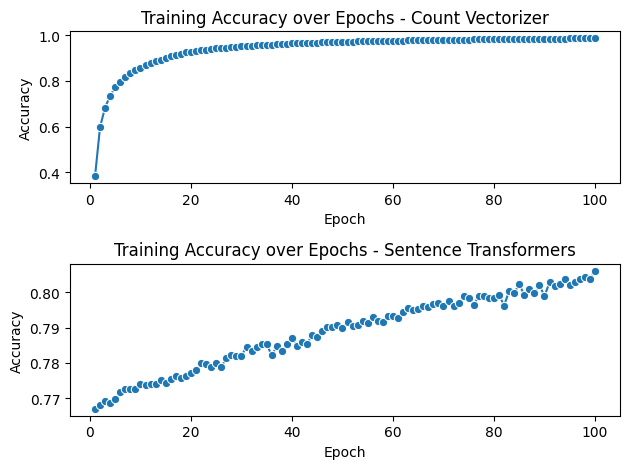

In [287]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming train_accuracies and train_losses are lists containing the accuracy and loss values for each epoch

# Create a DataFrame for the accuracies and losses with corresponding epoch numbers
accuracy_loss_df = pd.DataFrame({
    'Epoch': range(1, NUM_EPOCHS + 1),
    'Accuracy_cv': train_accuracies_cv,
    'Accuracy_st': train_accuracies_st
})

# Set up the figure with two subplots
# plt.figure(figsize=(12, 10))

# Plot for training accuracy
plt.subplot(2, 1, 1)
sns.lineplot(data=accuracy_loss_df, x='Epoch', y='Accuracy_cv', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs - Count Vectorizer')

# Plot for training loss
plt.subplot(2, 1, 2)
sns.lineplot(data=accuracy_loss_df, x='Epoch', y='Accuracy_st', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy over Epochs - Sentence Transformers')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


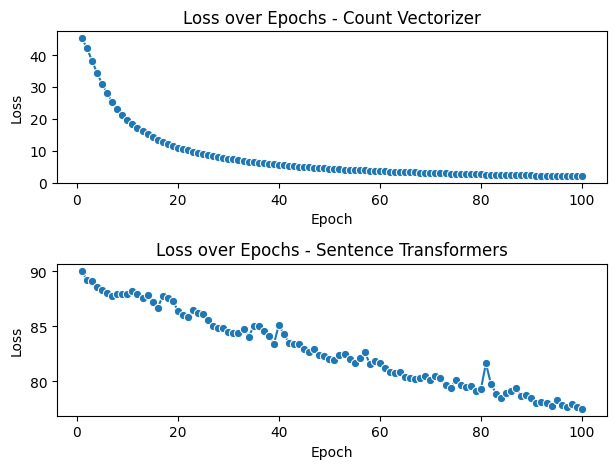

In [289]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Assuming train_accuracies and train_losses are lists containing the accuracy and loss values for each epoch

# Create a DataFrame for the accuracies and losses with corresponding epoch numbers
accuracy_loss_df = pd.DataFrame({
    'Epoch': range(1, NUM_EPOCHS + 1),
    'loss_cv': train_losses_cv,
    'loss_st': train_losses_st
})

# Set up the figure with two subplots
# plt.figure(figsize=(12, 10))

# Plot for training accuracy
plt.subplot(2, 1, 1)
sns.lineplot(data=accuracy_loss_df, x='Epoch', y='loss_cv', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs - Count Vectorizer')

# Plot for training loss
plt.subplot(2, 1, 2)
sns.lineplot(data=accuracy_loss_df, x='Epoch', y='loss_st', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs - Sentence Transformers')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


#### GLOVE WORD VECTORS

In [2]:
import torchtext.vocab as vocab


glove  = vocab.GloVe(name='6B',dim=100)

In [3]:
glove.vectors.shape

torch.Size([400000, 100])

In [4]:
####words in vocab

glove.itos[:5]

['the', ',', '.', 'of', 'to']

In [5]:
# index of embedding for the word
glove.stoi

{'the': 0,
 ',': 1,
 '.': 2,
 'of': 3,
 'to': 4,
 'and': 5,
 'in': 6,
 'a': 7,
 '"': 8,
 "'s": 9,
 'for': 10,
 '-': 11,
 'that': 12,
 'on': 13,
 'is': 14,
 'was': 15,
 'said': 16,
 'with': 17,
 'he': 18,
 'as': 19,
 'it': 20,
 'by': 21,
 'at': 22,
 '(': 23,
 ')': 24,
 'from': 25,
 'his': 26,
 "''": 27,
 '``': 28,
 'an': 29,
 'be': 30,
 'has': 31,
 'are': 32,
 'have': 33,
 'but': 34,
 'were': 35,
 'not': 36,
 'this': 37,
 'who': 38,
 'they': 39,
 'had': 40,
 'i': 41,
 'which': 42,
 'will': 43,
 'their': 44,
 ':': 45,
 'or': 46,
 'its': 47,
 'one': 48,
 'after': 49,
 'new': 50,
 'been': 51,
 'also': 52,
 'we': 53,
 'would': 54,
 'two': 55,
 'more': 56,
 "'": 57,
 'first': 58,
 'about': 59,
 'up': 60,
 'when': 61,
 'year': 62,
 'there': 63,
 'all': 64,
 '--': 65,
 'out': 66,
 'she': 67,
 'other': 68,
 'people': 69,
 "n't": 70,
 'her': 71,
 'percent': 72,
 'than': 73,
 'over': 74,
 'into': 75,
 'last': 76,
 'some': 77,
 'government': 78,
 'time': 79,
 '$': 80,
 'you': 81,
 'years': 82,
 'i

In [58]:
n = glove.stoi['number']
emb = glove.vectors[n]

In [6]:
### FUNCTION OF WORD EMBEDDING
# def get_embedding_vector(word):
#     word_index = glove.stoi[word]
#     emb = glove.vectors[word_index]
#     return emb

def get_word_embedding(word):
    '''return tensor Vector of a Word'''
    try:
        index_word = glove.stoi[word]
    except:
        print('EXCEPTION: word out of Vocab!!! ---->',word)
    emb = glove.vectors[index_word]

    return emb
get_word_embedding('chess').cpu().numpy()


array([ 3.7635e-01,  5.4567e-01,  3.0534e-01,  9.0395e-01, -8.8172e-02,
        6.2945e-01,  4.0376e-01, -8.1160e-01, -1.9370e-01, -3.1395e-01,
       -1.6067e-02, -6.8291e-01, -1.2400e-02, -2.0827e-01, -1.0267e+00,
        1.4386e+00,  5.1816e-01,  2.0026e-01, -8.3672e-04, -2.9563e-01,
       -7.5463e-01,  1.9618e-01,  6.0900e-01,  3.6774e-01,  7.2106e-01,
       -8.6832e-01, -2.1198e-01, -4.3051e-01,  7.1873e-01,  7.5019e-01,
       -6.0245e-01,  7.5618e-01, -5.5033e-01, -6.6510e-01,  5.3047e-01,
       -2.2391e-01, -9.2297e-01,  6.2659e-01, -2.5183e-01, -8.2082e-01,
       -1.6507e-01,  2.9234e-01, -2.6373e-01, -8.1124e-01, -4.0006e-02,
       -1.3341e-01,  2.9392e-01, -4.4894e-01,  5.6080e-02,  3.9754e-01,
       -6.8598e-01, -3.4001e-01, -1.1112e-02,  7.5445e-01,  2.8091e-01,
       -1.4169e+00,  2.7837e-01,  3.4846e-01,  1.3482e-01,  1.2508e+00,
       -8.0446e-02,  4.9207e-01, -7.0844e-01,  6.3239e-01, -3.8550e-01,
       -4.9367e-01, -2.1818e-01,  7.6461e-01,  6.3680e-01,  1.04

In [15]:
from tqdm import tqdm
import torch
def get_closest_words_from_inputword(word=None, emb_word=None, no_close_words=10):
    if emb_word is None:
        emb_word = get_word_embedding(word)
    
    # Using list comprehension to compute distances
    distances = [
        (glove.itos[wrd], torch.dist(emb_word, get_word_embedding(glove.itos[wrd])).cpu().item())
        for wrd in range(len(glove.itos))
    ]
    
    # Sort the distances and get the closest words
    close_word_list = sorted(distances, key=lambda x: x[1])[:no_close_words]
    
    return close_word_list

# Example usage
closest_words = get_closest_words_from_inputword(word='chess', no_close_words=5)
print(closest_words)


[('chess', 0.0), ('backgammon', 4.379469394683838), ('grandmasters', 4.56368350982666), ('grandmaster', 4.613785743713379), ('scrabble', 4.677640438079834)]


In [12]:
# Finding Analogies between words (sister:brother::niece:nephew), given 3 of these, predict the 4th word similar
def analogy_formula(w1,w2,w3):
        return (w1-w2)+w3

def get_word_analogy(word1,word2,word3,max_n=5):

    emb_word1 = get_word_embedding(word1)
    emb_word2 = get_word_embedding(word2)
    emb_word3 = get_word_embedding(word2)
    emb_word4 = analogy_formula(emb_word1,emb_word2,emb_word3)
    analogy_words = get_closest_words_from_inputword(emb_word=emb_word4,no_close_words=max_n)
    return analogy_words


get_word_analogy('sister','brother','newphew',5)

[('sister', 8.071276624832535e-08),
 ('mother', 2.9683125019073486),
 ('daughter', 3.035046339035034),
 ('wife', 3.3465774059295654),
 ('niece', 3.447561025619507)]

In [14]:

get_word_analogy('sister','brother','newphew',5)

[('sister', 8.071276624832535e-08),
 ('mother', 2.9683125019073486),
 ('daughter', 3.035046339035034),
 ('wife', 3.3465774059295654),
 ('niece', 3.447561025619507)]

In [21]:
categories = ['animal','person','food','travel','environment','technology','colors','vehicle','city','water']
results = []
for category in categories:
    closest_words = get_closest_words_from_inputword(word=category, no_close_words=10)
    print(closest_words)
    for tuple in closest_words:
        results.append(tuple[0])
        

  0%|                                                                                                                                                                              | 0/400000 [20:44<?, ?it/s]


[('animal', 0.0), ('animals', 3.2533745765686035), ('human', 4.271686553955078), ('livestock', 4.470293998718262), ('insect', 4.503368377685547), ('dog', 4.52310037612915), ('pet', 4.5668416023254395), ('elephant', 4.5978498458862305), ('pig', 4.643136978149414), ('nature', 4.666110515594482)]
[('person', 0.0), ('someone', 3.5700175762176514), ('anyone', 3.7407426834106445), ('man', 3.88858962059021), ('else', 3.9210364818573), ('every', 3.9233028888702393), ('same', 3.969043254852295), ('one', 4.003580570220947), ('actually', 4.0099053382873535), ('instance', 4.0524821281433105)]
[('food', 0.0), ('foods', 4.3919806480407715), ('supplies', 4.612394332885742), ('products', 4.651028633117676), ('meat', 4.836217880249023), ('supply', 4.852470397949219), ('feed', 4.88163423538208), ('medicines', 4.995121002197266), ('coffee', 5.028947830200195), ('nutrition', 5.044032573699951)]
[('travel', 0.0), ('traveling', 3.824260711669922), ('trips', 3.9174163341522217), ('travelers', 3.9461207389831

In [22]:
all_category =[]
for x in categories:

    all_category.extend([x]*10)

In [24]:
import pandas as pd

cloud_words = pd.DataFrame({'category':all_category,'values':results})

cloud_words

,category,values
0,animal,animal
1,animal,animals
2,animal,human
3,animal,livestock
4,animal,insect
...,...,...
95,water,dry
96,water,salt
97,water,drinking
98,water,reservoir


In [31]:
%%time
n_row = cloud_words.shape[0]
n_col = 100

tensors = torch.empty((n_row,n_col))
for x in range(n_row):
    current_word = results[x]
    tensors[x,:] = get_word_embedding(current_word)
    

CPU times: user 3.54 ms, sys: 5.87 ms, total: 9.41 ms
Wall time: 6.63 ms


In [33]:
tensors.shape

torch.Size([100, 100])

In [34]:
from sklearn.manifold import TSNE

In [36]:
tsne = TSNE(n_components=2)
tensor_tsne = tsne.fit_transform(tensors)

In [38]:
tensor_tsne.shape

(100, 2)

In [39]:
cloud_words['x'] = tensor_tsne[:,0]
cloud_words['Y'] = tensor_tsne[:,1]

In [41]:
pip install plotnine

DEPRECATION: Loading egg at /Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/jupyter-1.0.0-py3.11.egg is deprecated. pip 24.3 will enforce this behaviour change. A possible replacement is to use pip for package installation. Discussion can be found at https://github.com/pypa/pip/issues/12330
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 9.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.4/127.4 kB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 2.7 MB/s eta 0:00:0000:010:01m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 4.3 MB/s eta 0:00:00a 0:00:01

[notice] A new release of pip is available: 24.1 -> 24.1.1
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [48]:
cloud_words

,category,values,x,Y
0,animal,animal,-7.669181,1.734225
1,animal,animals,-7.539567,1.578473
2,animal,human,-6.751885,0.177253
3,animal,livestock,-7.027286,2.464252
4,animal,insect,-8.400879,1.070334
...,...,...,...,...
95,water,dry,-1.470476,3.713561
96,water,salt,-0.801226,4.547015
97,water,drinking,-2.902090,4.878926
98,water,reservoir,-0.861286,6.074540


In [83]:
words = []
categories = ['number', 'algebra', 'music', 'science', 'technology']

df_word_cloud = pd.DataFrame({
    'category': [],
    'word': []
})

for category in categories:
    print(category)
    closest_words = get_closest_words_from_inputword(word=category, no_close_words=20)
    temp = pd.DataFrame({
        'category': [category] * len(closest_words),
        'word': [x[0] for x in closest_words]
    })
    df_word_cloud = pd.concat([df_word_cloud, temp], ignore_index=True)
    

df_word_cloud


number
algebra
music
science
technology


,category,word
0,number,number
1,number,numbers
2,number,only
3,number,addition
4,number,ten
...,...,...
95,technology,applications
96,technology,innovations
97,technology,developing
98,technology,research


In [87]:
# %% get the 100 dimension word embedding for all words
n_rows = df_word_cloud.shape[0]
n_cols = 100
X = torch.empty((n_rows, n_cols))
for i in range(n_rows):
    current_word = df_word_cloud.loc[i, 'word']
    X[i, :] = get_word_embedding(current_word)
    print(f"{i}: {current_word}")
# %%
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X.cpu().numpy())
# %%
df_word_cloud['x'] = X_tsne[:, 0]
df_word_cloud['y'] = X_tsne[:, 1]


0: number
1: numbers
2: only
3: addition
4: ten
5: one
6: many
7: same
8: among
9: although
10: least
11: both
12: these
13: several
14: some
15: included
16: all
17: other
18: though
19: few
20: algebra
21: algebras
22: geometry
23: heyting
24: homological
25: trigonometry
26: boolean
27: mathematics
28: algebraic
29: generalization
30: calculus
31: associative
32: formula_1
33: multiplication
34: arithmetic
35: commutative
36: isomorphic
37: linear
38: equivalently
39: quaternion
40: music
41: musical
42: dance
43: songs
44: pop
45: recording
46: folk
47: jazz
48: concert
49: musicians
50: contemporary
51: artists
52: soundtrack
53: hop
54: studio
55: song
56: tunes
57: singing
58: band
59: performing
60: science
61: sciences
62: physics
63: mathematics
64: studies
65: institute
66: biology
67: psychology
68: research
69: scientific
70: humanities
71: study
72: economics
73: literature
74: sociology
75: arts
76: chemistry
77: astronomy
78: journalism
79: professor
80: technology
81: 

In [88]:
df_word_cloud

,category,word,x,y
0,number,number,1.761723,-5.404210
1,number,numbers,2.205232,-5.678030
2,number,only,1.017511,-4.480808
3,number,addition,0.301814,-3.168355
4,number,ten,0.361250,-5.062890
...,...,...,...,...
95,technology,applications,3.842005,0.196073
96,technology,innovations,1.453008,0.801204
97,technology,developing,1.518552,-0.959450
98,technology,research,-0.952243,0.617694


/var/folders/r3/p7_fq8l12bs1bq7cn5b0f7tw0000gn/T/ipykernel_27663/2076015540.py:15: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


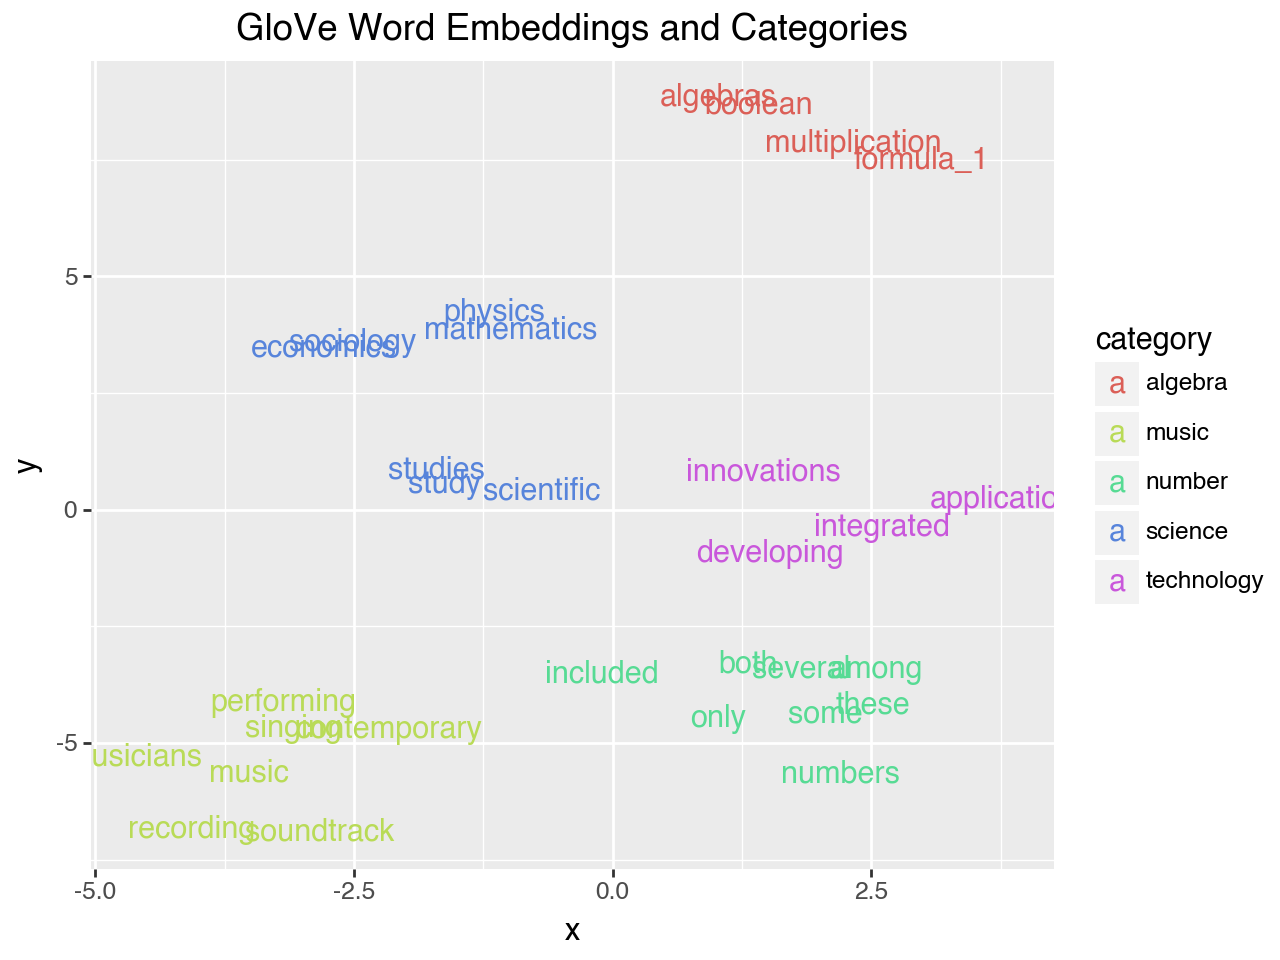

In [103]:
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import ggplot, aes, geom_text, labs

# Set figure size in inches (width, height)
fig = plt.figure(figsize=(10, 5))

# Create the ggplot
p = (ggplot(data=df_word_cloud.sample(30)) 
     + aes(x='x', y='y', label='word', color='category') 
     + geom_text() 
     + labs(title='GloVe Word Embeddings and Categories'))

# Show the plot
print(p)